# Prediction of NBA fantasy scores

This notebook is an experiment to see if we could use machine learning models to predict the fantasy production of NBA players. We plan on comparing two techniques, a MLP regressor and a decision tree regressor.  

Credit to https://www.kaggle.com/jwals96/nba-201718-stats-and-fantasy-scores for the dataset we plan on using.

## Preparing the data

### Ingesting and interpreting the dataset

We'll start by simply using pandas to read our `.csv` file containing the dataset.  
Our dataset is made up of many features, such as: 
- Player season averages (points, rebounds, assists, shooting percentage, etc.)
- Information about specific game (date, home team, etc.)
- Information about the opponent.
- The players fantasy score.
Every example in our dataset corresponds to a player's fantasy production for a specific game.  

In [3]:
import pandas as pd
import numpy as np

In [6]:
dataset_raw = pd.read_csv("NBA Stats Database - Player Game Stats 2017 (1).csv")
dataset_raw.head(5)

,Name,Position,(NBAS Team),(BBref Team),DK Team,(Team),(vs.),(NBAS Opponent),(BBref Opponent),DK Opponent,...,Player FT%,Player ORB,Player DRB,Player TRB,Player AST,Player STL,Player BLK,Player TOV,Player PF,Player PS/G
0,Aaron Brooks,PG,MIN,MIN,Min,MIN,vs.,IND,IND,Ind,...,0.727,0.2,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
1,Aaron Brooks,PG,MIN,MIN,Min,MIN,@,DET,DET,Det,...,0.727,0.2,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
2,Aaron Brooks,PG,MIN,MIN,Min,MIN,@,GSW,GSW,GS,...,0.727,0.2,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
3,Aaron Brooks,PG,MIN,MIN,Min,MIN,vs.,CHA,CHO,Cha,...,0.727,0.2,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
4,Aaron Brooks,PG,MIN,MIN,Min,MIN,@,DAL,DAL,Dal,...,0.727,0.2,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3


Let's explore our data just to have a better idea of what is available to us.

In [7]:
#columns
print("All columns in the dataset:")
print(list(dataset_raw))
print()

# Shape of the dataset
print("Number of examples in the dataset: ", dataset_raw.shape[0])
print("Number of columns in the dataset: ", dataset_raw.shape[1])
print()

# Information about each column
'''
for column in list(dataset_raw):
    print(dataset_raw[column].value_counts())
    print()
'''

All columns in the dataset:
['Name', 'Position', '(NBAS Team)', '(BBref Team)', 'DK Team', '(Team)', '(vs.)', '(NBAS Opponent)', '(BBref Opponent)', 'DK Opponent', 'Home', 'Match Up', 'Date', 'Min', '(Double digit stats)', '(Unadj Pts)', 'DK Points Scored', 'Team Points ', 'Player Avg Pts/min', 'Team Avg Pace', 'Opponent Avg Pace', 'Team FG', 'Team FGA', 'Team FG%', 'Team 3P', 'Team 3PA', 'Team 3P%', 'Team 2P', 'Team 2PA', 'Team 2P%', 'Team FT', 'Team FTA', 'Team FT%', 'Team ORB', 'Team DRB', 'Team TRB', 'Team AST', 'Team STL', 'Team BLK', 'Team TOV', 'Team PF', 'Team Avg Points', 'Opp FG', 'Opp FGA', 'Opp FG%', 'Opp 3P', 'Opp 3PA', 'Opp 3P%', 'Opp 2P', 'Opp 2PA', 'Opp 2P%', 'Opp FT', 'Opp FTA', 'Opp FT%', 'Opp ORB', 'Opp DRB', 'Opp TRB', 'Opp AST', 'Opp STL', 'Opp BLK', 'Opp TOV', 'Opp PF', 'Opp Avg PTS', 'Player Age', 'Player FG', 'Player FGA', 'Player FG%', 'Player 3P', 'Player 3PA', 'Player 3P%', 'Player 2P', 'Player 2PA', 'Player 2P%', 'Player eFG%', 'Player FT', 'Player FTA', 'Pl

'\nfor column in list(dataset_raw):\n    print(dataset_raw[column].value_counts())\n    print()\n'

# TODO CLEAN DATA THE RIGTH WAY

In [85]:
'''
for i in dataset_raw.isnull().sum():
    print(i)
print("-----------------------")
'''
#dataset_raw = dataset_raw[:27020]
dataset_raw = dataset_raw.dropna()
'''
print("-----------------------")
for i in dataset_raw.isnull().sum():
    print(i)
'''

'\nprint("-----------------------")\nfor i in dataset_raw.isnull().sum():\n    print(i)\n'

# END OF TODO

We plan to use different versions of the dataset to see which one performs the best. To do so, we think we should try to classify each feature of the dataset and then base our versions of the dataset on those categories. We decided to define the following categories:
- **Main**: Those are features that we think belong in every dataset because we see them as having a good value.
- **Derived**: Other feature(s) offers similar information or can litteraly be used to derive the feature.
- **Useless**: Information is useless (e.g. '(vs.)').
- **Not predictive**: Column offers no predictive value. I.e. it cannot be a feature in the test set.
- **Optional**: We believe the column offers little value. This is very subjective, which leaves us room for experimentation.  

Let's classify our features and explain a bit. This is going to be quite long, so please feel free to skip this: 


| Feature | Category | Justification |
|:--------|:---------|:--------------|
| 'Name' | **Optional** | we think a players stats should define him well enough. Also, on-hot encoding of this column would add 500+ features. |  
| 'Position' | **Optional** | This is a bit 'inside baseball', but the modern move towards positionless basketball makes us think adding this feature wouldn't be usefull enough. |
| '(NBAS Team)' | **Optional** | We don't believe knowing the team adds something if we know the team stats. Also, playing agains Miami in 2012 isn't the same as Miami in 2019, so there is a time constraint on this feature. |
| '(BBref Team)' | **Useless** | This is also the team, see '(NBAS Team)' |
| 'DK Team' | **Useless** | This is also the team, see '(NBAS Team)' |
| '(Team)' | **Useless** | This is also the team, see '(NBAS Team)' |
| '(vs.)' | **Useless** | This is useless. |
| 'DK Opponent' | **Optional** | We believe knowing the opponent has limited value if we know the opponent stats. |
| '(NBAS Opponent)' | **Useless** |  This is also the opponent, see 'DK Opponent' |
| '(BBref Opponent)' | **Useless** | This is also the opponent, see 'DK Opponent' |
| 'Home' | **Main** | Knowing if the game is at home seems very interesting as home court advantage is big in basketball. |
| 'Match Up' | **Useless** | This is just a combination of team and opponent, so same reasonning. |
| 'Date' | **Optional** | Wethink the date should not have to much impact, especially the exact date. Maybe the month can catch some trends. However, we will use this feature to do some changes later on. |
| 'Min' | **Not predictive** | This is the number of minute played for a game. We don't know this beforehand, so no predictive value. |
| '(Double digit stats)' | **Main** | Unfortunatly, we're not sure what this is, so we'll ignore it for now. It seems like it says how many of the player's stats were in double digit, which once again is not know beforhand so no predictive value. |
| '(Unadj Pts)' | **Useless** | We made the design decision that our label column would be 'DK Points scored'. This column offers roughly the same information. |
| 'DK Points Scored' | **Main** | This is our label column. Essential. |
| 'Team Points' | **Not predictive** | This is the points the team scored. We don't know this beforehand, no predictive value. |
| 'Player Avg Pts/min' | **Main** | This seems interesting since points are a big part of fantasy production. |
| 'Team Avg Pace' | **Main** | Interesting since the higher the pace, the more chances there are to score for the player. |
| 'Opponent Avg Pace' | **Main** | Same reasoning as 'Team Avg Pace'. |
| 'Team FG' | **Main** | Team average field goal made per game. We find it interesting, though it's similar to the pace. |
| 'Team FGA' | **Main** | Team average field goal attemps per game. We find it interesting, though it's similar to the pace. |
| 'Team FG%' | **Derived** | While useful, it's fairly similiar to having both 'Team FG' and 'Team FGA'. |
| 'Team 3P' | **Main** | Same reasoning as 'Team FG' |
| 'Team 3PA' | **Main** | Same reasoning as 'Team FGA' | 
| 'Team 3P%' | **Derived** | Same reasoning as 'Team FG%' | 
| 'Team 2P' | **Main** | Same reasoning as 'Team FG' | 
| 'Team 2PA' | **Main** | Same reasoning as 'Team FGA' |
| 'Team 2P%' | **Derived** | Same reasoning as 'Team FG%' | 
| 'Team FT' | **Main** | Same reasoning as 'Team FG' | 
| 'Team FTA' | **Main** | Same reasoning as 'Team FGA' | 
| 'Team FT%' | **Derived** | Same reasoning as 'Team FG%' | 
| 'Team ORB' | **Main** |  | 
| 'Team DRB' | **Main** |  |
| 'Team TRB' | **Derived** |  |
| 'Team AST' | **Main** |  |
| 'Team STL' | **Main** |  |
| 'Team BLK' | **Main** |  |
| 'Team TOV' | **Main** |  |
| 'Team PF' | **Optional** |  |
| 'Team Avg Points' | **Main** |  |
| 'Opp FG' | **Main** |  |
| 'Opp FGA' | **Main** |  |
| 'Opp FG%' | **Derived** |  |
| 'Opp 3P' | **Main** |  |
| 'Opp 3PA' | **Main** |  |
| 'Opp 3P%' | **Derived** |  |
| 'Opp 2P' | **Main** |  |
| 'Opp 2PA' | **Main** |  |
| 'Opp 2P%' | **Derived** |  |
| 'Opp FT' | **Main** |  |
| 'Opp FTA' | **Main** |  |
| 'Opp FT%' | **Derived** |  |
| 'Opp ORB' | **Main** |  |
| 'Opp DRB' | **Main** |  |
| 'Opp TRB' | **Derived** |  |
| 'Opp AST' | **Main** |  |
| 'Opp STL' | **Main** |  |
| 'Opp BLK' | **Main** |  |
| 'Opp TOV' | **Main** |  |
| 'Opp PF' | **Main** |  |
| 'Opp Avg PTS' | **Main** |  |
| 'Player Age' | **Main** |  |
| 'Player FG' | **Main** |  |
| 'Player FGA' | **Main** |  |
| 'Player FG%' | **Derived** |  |
| 'Player 3P' | **Main** |  |
| 'Player 3PA' | **Main** |  |
| 'Player 3P%' | **Derived** |  |
| 'Player 2P' | **Main** |  |
| 'Player 2PA' | **Main** |  |
| 'Player 2P%' | **Derived** |  |
| 'Player eFG%' | **Derived** |  |
| 'Player FT' | **Main** |  |
| 'Player FTA' | **Main** |  |
| 'Player FT%' | **Derived** |  |
| 'Player ORB' | **Main** |  |
| 'Player DRB' | **Main** |  |
| 'Player TRB' | **Derived** |  |
| 'Player AST' | **Main** |  |
| 'Player STL' | **Main** |  |
| 'Player BLK' | **Main** |  |
| 'Player TOV' | **Main** |  |
| 'Player PF' | **Main** |  |
| 'Player PS/G' | **Main** |  |


### Remodeling the dataset

Like we mentionned earlier, we want to use different versions of the dataset to see how different mix of feature might change performance. We decided to have three versions

**Version 1: Full dataset**  
This dataset will pretty much be the original dataset, but we'll remove features that we classified as **Useless** or **Not Predictive**. For the other features, we'll make no or very little changes.  

**Version 2: Lightweight dataset**  
In this dataset, we'll only keep the features we classified as **Main**. The idea is that the features classified as **Derived** or **Optional** offer information that we can already get with the **Main** features. We might do small changes to the features in this dataset.  

**Version 3: Fully custom**  
This is pretty much the version 2 dataset, but we'll make quite a bit of changes. We'll detail them in the section reserved for the creation of the version 3 dataset.

First, let's pop our target column as it's the same for all our datasets.

In [9]:
#isolating cell because it can only be run once
y = dataset_raw.pop('DK Points Scored')

Now we'll apply changes that we will be using on all our datasets

In [10]:
# replace the date by a 'month' feature
dataset_raw['Date'] = pd.to_datetime(dataset_raw['Date'], errors='coerce')
dataset_raw['Month'] = dataset_raw['Date'].dt.month
dataset_raw.pop('Date')

1       2017-10-25
2       2017-11-08
3       2017-11-05
4       2017-11-17
5       2017-11-04
           ...    
27023   2017-12-20
27024   2017-12-13
27025   2017-12-11
27026   2017-12-09
27027   2017-12-18
Name: Date, Length: 25818, dtype: datetime64[ns]

#### Creating the Version 1 dataset: Original dataset

As we mentionned earlier, the version 1 dataset, but without the features we classified as **Useless** or **Not Predictive**. The only change we will make is the one-hot encoding of discrete features (and 'Month', which is technically numeric).

In [89]:
full_feature_set = ['Name', 'Position', '(NBAS Team)', 'DK Opponent', 'Home', '(Double digit stats)', 
                    'Player Avg Pts/min', 'Team Avg Pace', 'Opponent Avg Pace', 'Team FG', 
                    'Team FGA', 'Team FG%', 'Team 3P', 'Team 3PA', 'Team 3P%', 'Team 2P', 'Team 2PA', 'Team 2P%', 
                    'Team FT', 'Team FTA', 'Team FT%', 'Team ORB', 'Team DRB', 'Team TRB', 'Team AST', 'Team STL', 
                    'Team BLK', 'Team TOV', 'Team PF', 'Team Avg Points', 'Opp FG', 'Opp FGA', 'Opp FG%', 'Opp 3P', 
                    'Opp 3PA', 'Opp 3P%', 'Opp 2P', 'Opp 2PA', 'Opp 2P%', 'Opp FT', 'Opp FTA', 'Opp FT%', 'Opp ORB', 
                    'Opp DRB', 'Opp TRB', 'Opp AST', 'Opp STL', 'Opp BLK', 'Opp TOV', 'Opp PF', 'Opp Avg PTS', 
                    'Player Age', 'Player FG', 'Player FGA', 'Player FG%', 'Player 3P', 'Player 3PA', 'Player 3P%', 
                    'Player 2P', 'Player 2PA', 'Player 2P%', 'Player eFG%', 'Player FT', 'Player FTA', 'Player FT%', 
                    'Player ORB', 'Player DRB', 'Player TRB', 'Player AST', 'Player STL', 'Player BLK', 'Player TOV', 
                    'Player PF', 'Player PS/G', 'Month']

X_full_ft = dataset_raw[full_feature_set].copy()
X_full_ft.head(5)

# one hot encoding 'Name', 'Position', '(NBAS Team)', 'DK Opponent' and 'Month'
one_hot_name = pd.get_dummies(X_full_ft['Name'], prefix = 'player')
one_hot_position = pd.get_dummies(X_full_ft['Position'], prefix = 'position')
one_hot_team = pd.get_dummies(X_full_ft['(NBAS Team)'], prefix = 'team')
one_hot_opponent = pd.get_dummies(X_full_ft['DK Opponent'], prefix = 'opponent')
one_hot_month = pd.get_dummies(X_full_ft['Month'], prefix = 'month')


X_full_ft = pd.concat([X_full_ft, one_hot_name, one_hot_position, one_hot_team, one_hot_opponent, one_hot_month], axis=1)
X_full_ft.pop('Name')
X_full_ft.pop('Position')
X_full_ft.pop('(NBAS Team)')
X_full_ft.pop('DK Opponent')
X_full_ft.pop('Month')
print(X_full_ft.shape)
print(list(X_full_ft))

(25818, 602)
['Home', '(Double digit stats)', 'Player Avg Pts/min', 'Team Avg Pace', 'Opponent Avg Pace', 'Team FG', 'Team FGA', 'Team FG%', 'Team 3P', 'Team 3PA', 'Team 3P%', 'Team 2P', 'Team 2PA', 'Team 2P%', 'Team FT', 'Team FTA', 'Team FT%', 'Team ORB', 'Team DRB', 'Team TRB', 'Team AST', 'Team STL', 'Team BLK', 'Team TOV', 'Team PF', 'Team Avg Points', 'Opp FG', 'Opp FGA', 'Opp FG%', 'Opp 3P', 'Opp 3PA', 'Opp 3P%', 'Opp 2P', 'Opp 2PA', 'Opp 2P%', 'Opp FT', 'Opp FTA', 'Opp FT%', 'Opp ORB', 'Opp DRB', 'Opp TRB', 'Opp AST', 'Opp STL', 'Opp BLK', 'Opp TOV', 'Opp PF', 'Opp Avg PTS', 'Player Age', 'Player FG', 'Player FGA', 'Player FG%', 'Player 3P', 'Player 3PA', 'Player 3P%', 'Player 2P', 'Player 2PA', 'Player 2P%', 'Player eFG%', 'Player FT', 'Player FTA', 'Player FT%', 'Player ORB', 'Player DRB', 'Player TRB', 'Player AST', 'Player STL', 'Player BLK', 'Player TOV', 'Player PF', 'Player PS/G', 'player_Aaron Brooks', 'player_Aaron Gordon', 'player_Aaron Harrison', 'player_Abdel Nader'

#### Creating the Version 2 dataset: Lightweight dataset

For this version of the dataset, we want minimise the number of features and see if we can get similar performance. This means that we'll only keep features categorized as **Main**.

In [12]:
lightweight_feature_set = ['Home', '(Double digit stats)', 'Player Avg Pts/min', 'Team Avg Pace', 'Opponent Avg Pace', 
                           'Team FG', 'Team FGA', 'Team 3P', 'Team 3PA', 'Team 2P', 'Team 2PA', 'Team FT', 'Team FTA', 
                           'Team TRB', 'Team AST', 'Team STL', 'Team BLK', 'Team TOV', 'Team PF', 
                           'Team Avg Points', 'Opp FG', 'Opp FGA', 'Opp 3P', 'Opp 3PA', 'Opp 2P', 'Opp 2PA', 'Opp FT', 
                           'Opp FTA', 'Opp TRB', 'Opp AST', 'Opp STL', 'Opp BLK', 'Opp TOV', 'Opp PF', 
                           'Opp Avg PTS', 'Player Age', 'Player FG', 'Player FGA', 'Player 3P', 'Player 3PA', 'Player 2P', 
                           'Player 2PA', 'Player FT', 'Player FTA', 'Player TRB', 'Player AST', 'Player STL', 
                           'Player BLK', 'Player TOV', 'Player PF', 'Player PS/G']

X_lightweight_ft = dataset_raw[lightweight_feature_set].copy()
X_lightweight_ft.head(5)

,Home,(Double digit stats),Player Avg Pts/min,Team Avg Pace,Opponent Avg Pace,Team FG,Team FGA,Team 3P,Team 3PA,Team 2P,...,Player 2PA,Player FT,Player FTA,Player TRB,Player AST,Player STL,Player BLK,Player TOV,Player PF,Player PS/G
1,0,0,0.716,96.84,96.81,41.0,86.1,8.0,22.5,33.0,...,1.2,0.3,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
2,0,0,0.716,96.84,100.43,41.0,86.1,8.0,22.5,33.0,...,1.2,0.3,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
3,1,0,0.716,96.84,98.74,41.0,86.1,8.0,22.5,33.0,...,1.2,0.3,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
4,0,0,0.716,96.84,96.61,41.0,86.1,8.0,22.5,33.0,...,1.2,0.3,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3
5,1,0,0.716,96.84,96.61,41.0,86.1,8.0,22.5,33.0,...,1.2,0.3,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3


#### Creating the Version 3 dataset: Fully custom

For this dataset, we want to make changes that we feel will make the data more compeling.  

Our dataset has a lot of stats, but they are season averages. We feel this isn't applicable to the whole season. What we decided to do is replace most of them by the average by month. We not only feel that this will make the model more applicable to the whole season, but we also think we could capture the idea of a player being "on fire" for a streach of time.  

To accomplish this, we'll use the [NBA Stats](https://stats.nba.com/) API. Now, this API isn't really well documented. So to get the info we needed, we had to manually use the [NBA Stats](https://stats.nba.com/) website and look around in the network inspector. So please excuse the less than stellar code.  

First, let's define the initial features we want. This dataset will be a mix of the previous two, with some feature removed because of changes we want to make later on.

In [13]:
'''
custom_feature_set = ['Name', 'DK Team', 'DK Opponent', 'Home', '(Double digit stats)', 
                    'Player Avg Pts/min', 'Team Avg Pace', 'Opponent Avg Pace', 'Team FG', 
                    'Team FGA', 'Team FG%', 'Team 3P', 'Team 3PA', 'Team 3P%', 'Team 2P', 'Team 2PA', 'Team 2P%', 
                    'Team FT', 'Team FTA', 'Team FT%', 'Team ORB', 'Team DRB', 'Team TRB', 'Team AST', 'Team STL', 
                    'Team BLK', 'Team TOV', 'Team PF', 'Team Avg Points', 'Opp FG', 'Opp FGA', 'Opp FG%', 'Opp 3P', 
                    'Opp 3PA', 'Opp 3P%', 'Opp 2P', 'Opp 2PA', 'Opp 2P%', 'Opp FT', 'Opp FTA', 'Opp FT%', 'Opp ORB', 
                    'Opp DRB', 'Opp TRB', 'Opp AST', 'Opp STL', 'Opp BLK', 'Opp TOV', 'Opp PF', 'Opp Avg PTS', 
                    'Player Age', 'Player FG', 'Player FGA', 'Player FG%', 'Player 3P', 'Player 3PA', 'Player 3P%', 
                    'Player 2P', 'Player 2PA', 'Player 2P%', 'Player eFG%', 'Player FT', 'Player FTA', 'Player FT%', 
                    'Player ORB', 'Player DRB', 'Player TRB', 'Player AST', 'Player STL', 'Player BLK', 'Player TOV', 
                    'Player PF', 'Player PS/G', 'Month']
'''

# May seem light, but we'll add a lot of data
custom_feature_set = ['Name', 'DK Team', 'DK Opponent', 'Home', 'Month']

X_custom_ft = dataset_raw[custom_feature_set].copy()

Second, let's replace the opponent team by the defensive rating of that team for the month. Defensive rating is an estimate of the points allowed per 100 possessions. We start by building a dictionary with the defensive rating by month for all teams.

In [14]:
import requests

In [15]:
URL = "https://stats.nba.com/stats/leaguedashteamstats/"

# A lot of these might seem useless since they have empty values, but the API behaves weirdly when you remove them.
PARAMS = {
    'Conference':'',
    'DateFrom':'',
    'DateTo':'',
    'Division':'',
    'GameScope':'',
    'GameSegment':'',
    'LastNGames':0,
    'LeagueID':'00',
    'Location':'',
    'MeasureType':'Defense',
    'Month':1, # this will be dynamically changed
    'OpponentTeamID':0,
    'Outcome':'',
    'PORound':0,
    'PaceAdjust':'N',
    'PerMode':'PerGame',
    'Period':0,
    'PlayerExperience':'',
    'PlayerPosition':'',
    'PlusMinus':'N',
    'Rank':'N',
    'Season':'2017-18',
    'SeasonSegment':'',
    'SeasonType':'Regular Season',
    'ShotClockRange':'',
    'StarterBench':'',
    'TeamID':0,
    'TwoWay':0,
    'VsConference':'',
    'VsDivision':''
}

# need to trick API into thinking we're a browser
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Safari/537.36'
}

def_ratings = {
    '10': {},
    '11': {},
    '12': {},
    '1': {},
    '2': {},
    '3': {},
    '4': {}
}

try:
    month_count = 1 #pretty ugly, do it better
    for month_rating in def_ratings:
        PARAMS['Month'] = month_count # this seems weird, but to the NBA API, October is month 1 and not 10
        r = requests.get(url = URL, params = PARAMS, headers = HEADERS) 
        data = r.json()
        for team_info in data['resultSets'][0]['rowSet']:
            def_ratings[month_rating][team_info[1]] = team_info[7]
        month_count+=1
except requests.exceptions.RequestException:
    '''
    Unfortunatly, the NBA stats API seems unstable. Luckly, we saved a run so the cell bellow can be used. 
    We prefered including the request to show that we did not do this manually.
    '''
    print("Caught RequestException, so we use the hard-coded backup")
    def_ratings = { '10': {'Atlanta Hawks': 106.7, 'Boston Celtics': 98.1, 'Brooklyn Nets': 111.0, 'Charlotte Hornets': 101.7, 'Chicago Bulls': 106.7, 'Cleveland Cavaliers': 111.6, 'Dallas Mavericks': 110.5, 'Denver Nuggets': 105.6, 'Detroit Pistons': 104.3, 'Golden State Warriors': 110.9, 'Houston Rockets': 105.1, 'Indiana Pacers': 107.4, 'LA Clippers': 101.0, 'Los Angeles Lakers': 101.4, 'Memphis Grizzlies': 99.3, 'Miami Heat': 108.8, 'Milwaukee Bucks': 106.1, 'Minnesota Timberwolves': 114.6, 'New Orleans Pelicans': 105.6, 'New York Knicks': 104.9, 'Oklahoma City Thunder': 98.4, 'Orlando Magic': 103.7, 'Philadelphia 76ers': 106.3, 'Phoenix Suns': 108.5, 'Portland Trail Blazers': 99.7, 'Sacramento Kings': 107.3, 'San Antonio Spurs': 102.7, 'Toronto Raptors': 96.7, 'Utah Jazz': 97.9, 'Washington Wizards': 101.1}, 
                    '11': {'Atlanta Hawks': 111.7, 'Boston Celtics': 100.3, 'Brooklyn Nets': 107.0, 'Charlotte Hornets': 111.9, 'Chicago Bulls': 109.5, 'Cleveland Cavaliers': 107.8, 'Dallas Mavericks': 104.3, 'Denver Nuggets': 108.7, 'Detroit Pistons': 106.2, 'Golden State Warriors': 99.6, 'Houston Rockets': 102.6, 'Indiana Pacers': 108.7, 'LA Clippers': 111.4, 'Los Angeles Lakers': 104.8, 'Memphis Grizzlies': 109.6, 'Miami Heat': 103.5, 'Milwaukee Bucks': 107.6, 'Minnesota Timberwolves': 106.1, 'New Orleans Pelicans': 107.4, 'New York Knicks': 107.6, 'Oklahoma City Thunder': 103.5, 'Orlando Magic': 112.0, 'Philadelphia 76ers': 103.8, 'Phoenix Suns': 110.4, 'Portland Trail Blazers': 101.0, 'Sacramento Kings': 110.9, 'San Antonio Spurs': 103.4, 'Toronto Raptors': 108.5, 'Utah Jazz': 105.0, 'Washington Wizards': 106.4}, 
                    '12': {'Atlanta Hawks': 110.4, 'Boston Celtics': 105.4, 'Brooklyn Nets': 107.0, 'Charlotte Hornets': 105.9, 'Chicago Bulls': 106.5, 'Cleveland Cavaliers': 110.0, 'Dallas Mavericks': 108.0, 'Denver Nuggets': 107.8, 'Detroit Pistons': 104.4, 'Golden State Warriors': 103.8, 'Houston Rockets': 111.5, 'Indiana Pacers': 110.7, 'LA Clippers': 106.3, 'Los Angeles Lakers': 112.2, 'Memphis Grizzlies': 111.8, 'Miami Heat': 108.8, 'Milwaukee Bucks': 112.1, 'Minnesota Timberwolves': 109.9, 'New Orleans Pelicans': 112.3, 'New York Knicks': 106.0, 'Oklahoma City Thunder': 106.2, 'Orlando Magic': 111.0, 'Philadelphia 76ers': 106.6, 'Phoenix Suns': 110.0, 'Portland Trail Blazers': 108.5, 'Sacramento Kings': 112.7, 'San Antonio Spurs': 103.9, 'Toronto Raptors': 103.2, 'Utah Jazz': 109.6, 'Washington Wizards': 106.2}, 
                    '1': {'Atlanta Hawks': 110.8, 'Boston Celtics': 99.1, 'Brooklyn Nets': 107.7, 'Charlotte Hornets': 106.5, 'Chicago Bulls': 112.9, 'Cleveland Cavaliers': 112.9, 'Dallas Mavericks': 108.3, 'Denver Nuggets': 108.7, 'Detroit Pistons': 110.3, 'Golden State Warriors': 112.6, 'Houston Rockets': 107.4, 'Indiana Pacers': 105.4, 'LA Clippers': 107.8, 'Los Angeles Lakers': 107.7, 'Memphis Grizzlies': 107.0, 'Miami Heat': 102.2, 'Milwaukee Bucks': 108.3, 'Minnesota Timberwolves': 109.4, 'New Orleans Pelicans': 107.3, 'New York Knicks': 110.9, 'Oklahoma City Thunder': 107.9, 'Orlando Magic': 112.6, 'Philadelphia 76ers': 104.0, 'Phoenix Suns': 112.1, 'Portland Trail Blazers': 110.7, 'Sacramento Kings': 111.0, 'San Antonio Spurs': 100.5, 'Toronto Raptors': 105.4, 'Utah Jazz': 105.9, 'Washington Wizards': 110.2}, 
                    '2': {'Atlanta Hawks': 107.3, 'Boston Celtics': 109.4, 'Brooklyn Nets': 113.6, 'Charlotte Hornets': 113.6, 'Chicago Bulls': 111.8, 'Cleveland Cavaliers': 112.9, 'Dallas Mavericks': 112.1, 'Denver Nuggets': 116.9, 'Detroit Pistons': 108.4, 'Golden State Warriors': 106.3, 'Houston Rockets': 103.5, 'Indiana Pacers': 106.7, 'LA Clippers': 108.7, 'Los Angeles Lakers': 106.8, 'Memphis Grizzlies': 110.9, 'Miami Heat': 107.6, 'Milwaukee Bucks': 106.9, 'Minnesota Timberwolves': 112.6, 'New Orleans Pelicans': 107.1, 'New York Knicks': 111.7, 'Oklahoma City Thunder': 111.6, 'Orlando Magic': 112.3, 'Philadelphia 76ers': 102.2, 'Phoenix Suns': 116.3, 'Portland Trail Blazers': 107.9, 'Sacramento Kings': 114.5, 'San Antonio Spurs': 111.1, 'Toronto Raptors': 103.7, 'Utah Jazz': 101.4, 'Washington Wizards': 109.2}, 
                    '3': {'Atlanta Hawks': 113.1, 'Boston Celtics': 103.7, 'Brooklyn Nets': 114.3, 'Charlotte Hornets': 112.3, 'Chicago Bulls': 112.7, 'Cleveland Cavaliers': 112.2, 'Dallas Mavericks': 107.7, 'Denver Nuggets': 113.1, 'Detroit Pistons': 105.0, 'Golden State Warriors': 107.1, 'Houston Rockets': 103.7, 'Indiana Pacers': 103.4, 'LA Clippers': 110.7, 'Los Angeles Lakers': 108.3, 'Memphis Grizzlies': 113.6, 'Miami Heat': 106.7, 'Milwaukee Bucks': 112.0, 'Minnesota Timberwolves': 113.0, 'New Orleans Pelicans': 106.3, 'New York Knicks': 114.6, 'Oklahoma City Thunder': 107.9, 'Orlando Magic': 104.9, 'Philadelphia 76ers': 102.3, 'Phoenix Suns': 113.9, 'Portland Trail Blazers': 104.7, 'Sacramento Kings': 109.1, 'San Antonio Spurs': 102.9, 'Toronto Raptors': 110.3, 'Utah Jazz': 97.5, 'Washington Wizards': 109.2}, 
                    '4': {'Atlanta Hawks': 105.9, 'Boston Celtics': 106.4, 'Brooklyn Nets': 108.0, 'Charlotte Hornets': 108.6, 'Chicago Bulls': 112.3, 'Cleveland Cavaliers': 110.4, 'Dallas Mavericks': 111.3, 'Denver Nuggets': 107.5, 'Detroit Pistons': 109.0, 'Golden State Warriors': 113.0, 'Houston Rockets': 104.9, 'Indiana Pacers': 109.7, 'LA Clippers': 120.5, 'Los Angeles Lakers': 106.4, 'Memphis Grizzlies': 118.5, 'Miami Heat': 105.4, 'Milwaukee Bucks': 108.8, 'Minnesota Timberwolves': 107.5, 'New Orleans Pelicans': 100.5, 'New York Knicks': 109.5, 'Oklahoma City Thunder': 104.7, 'Orlando Magic': 104.7, 'Philadelphia 76ers': 102.2, 'Phoenix Suns': 108.5, 'Portland Trail Blazers': 103.6, 'Sacramento Kings': 98.9, 'San Antonio Spurs': 109.0, 'Toronto Raptors': 100.2, 'Utah Jazz': 98.0, 'Washington Wizards': 109.9}}
    

Caught RequestException, so we use the hard-coded backup


Now that we have the information we need, let's add the feature to the dataset.

In [16]:
# first need to define a match between team names from NBA stats API and our dataset
team_name_acronymes = {
    'Hou':'Houston Rockets',
    'Sac':'Sacramento Kings',
    'Atl':'Atlanta Hawks',
    'SA':'San Antonio Spurs',
    'Pho':'Phoenix Suns',
    'Uta':'Utah Jazz',
    'Dal':'Dallas Mavericks',
    'Cha':'Charlotte Hornets',
    'Bos':'Boston Celtics',
    'OKC':'Oklahoma City Thunder',
    'LAL':'Los Angeles Lakers',
    'Orl':'Orlando Magic',
    'NY':'New York Knicks',
    'GS':'Golden State Warriors',
    'Tor':'Toronto Raptors',
    'Was':'Washington Wizards',
    'LAC':'LA Clippers',
    'NO':'New Orleans Pelicans',
    'Den':'Denver Nuggets',
    'Phi':'Philadelphia 76ers',
    'Chi':'Chicago Bulls',
    'Min':'Minnesota Timberwolves',
    'Bkn':'Brooklyn Nets',
    'Ind':'Indiana Pacers',
    'Mia':'Miami Heat',
    'Det':'Detroit Pistons',
    'Por':'Portland Trail Blazers',
    'Cle':'Cleveland Cavaliers',
    'Mil':'Milwaukee Bucks',
    'Mem':'Memphis Grizzlies'
}


def get_defensive_rating(row, acronyme_dict, ratings_dict):
    '''
    Return the defensive rating of the opponent (DK Opponent feature) in the given row.
    '''
    full_team_name = acronyme_dict[row['DK Opponent']]
    month = row['Month']
    return ratings_dict[str(month)][full_team_name]

# apply lamba on all rows of dataset to add a feature for opponent defensive rating
X_custom_ft['opp_def_rating'] = X_custom_ft.apply(lambda row: get_defensive_rating(row, team_name_acronymes, def_ratings), axis=1)

X_custom_ft.head(5)

,Name,DK Team,DK Opponent,Home,Month,opp_def_rating
1,Aaron Brooks,Min,Det,0,10,104.3
2,Aaron Brooks,Min,GS,0,11,99.6
3,Aaron Brooks,Min,Cha,1,11,111.9
4,Aaron Brooks,Min,Dal,0,11,104.3
5,Aaron Brooks,Min,Dal,1,11,104.3


Next, we'll add the monthly averages of the player's individual stats. We will follow the same pattern as we did for the defensive rating.

In [17]:
URL = "https://stats.nba.com/stats/leaguedashplayerstats/"

PARAMS = {
    'College':'',
    'Conference':'',
    'Country':'',
    'DateFrom':'',
    'DateTo':'',
    'Division':'',
    'DraftPick':'',
    'DraftYear':'',
    'GameScope':'',
    'GameSegment':'',
    'Height':'',
    'LastNGames':0,
    'LeagueID':'00',
    'Location':'',
    'MeasureType':'Base',
    'Month':1,
    'OpponentTeamID':0,
    'Outcome':'',
    'PORound':0,
    'PaceAdjust':'N',
    'PerMode':'PerGame',
    'Period':0,
    'PlayerExperience':'',
    'PlayerPosition':'',
    'PlusMinus':'N',
    'Rank':'N',
    'Season':'2017-18',
    'SeasonSegment':'',
    'SeasonType':'Regular Season',
    'ShotClockRange':'',
    'StarterBench':'',
    'TeamID':0,
    'TwoWay':0,
    'VsConference':'',
    'VsDivision':'',
    'Weight':''
}

#need to trick API into thinking we're a browser
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Safari/537.36'
}

player_month_stats = {
    '10': {},
    '11': {},
    '12': {},
    '1': {},
    '2': {},
    '3': {},
    '4': {}
}

month_count = 1 #pretty ugly, do it better
for month in player_month_stats:
    PARAMS['Month'] = month_count
    r = requests.get(url = URL, params = PARAMS, headers = HEADERS) 
    data = r.json()
    for player_info in data['resultSets'][0]['rowSet']:
        personal_stats = {}
        personal_stats['id'] = player_info[0]
        personal_stats['name'] = player_info[1]
        personal_stats['GP'] = player_info[5]
        personal_stats['min_avg'] = player_info[9]
        personal_stats['pts_avg'] = player_info[29]
        personal_stats['fgm_avg'] = player_info[10]
        personal_stats['fga_avg'] = player_info[11]
        personal_stats['fga_prct'] = player_info[12]
        personal_stats['3gm_avg'] = player_info[13]
        personal_stats['3ga_avg'] = player_info[14]
        personal_stats['3ga_prct'] = player_info[15]
        personal_stats['ftm_avg'] = player_info[16]
        personal_stats['fta_avg'] = player_info[17]
        personal_stats['fta_prct'] =player_info[18]
        personal_stats['oreb'] = player_info[19]
        personal_stats['dreb'] = player_info[20]
        personal_stats['reb'] = player_info[21]
        personal_stats['ast'] = player_info[22]
        personal_stats['tov'] = player_info[23]
        personal_stats['stl'] = player_info[24]
        personal_stats['blk'] = player_info[25]
        player_month_stats[month][player_info[1].replace(" ", "").lower()] = personal_stats
    month_count+=1

Now that we have our data, lets add it to the dataset

In [18]:
def gen_month_stats_dataset(df, player_month_stats):

    data = []
    bad_rows = []
    for index, row in df.iterrows():
        player = row['Name'].replace(" ", "").lower()
        month = row['Month']
        if(player in player_month_stats[str(month)]):
            player_stats = player_month_stats[str(month)][player]
            row = [player_stats['min_avg'], player_stats['pts_avg'], player_stats['fgm_avg'], player_stats['fga_avg'], 
                   player_stats['fga_prct'], player_stats['3gm_avg'], player_stats['3ga_avg'], player_stats['3ga_prct'], 
                   player_stats['ftm_avg'], player_stats['fta_avg'], player_stats['fta_prct'], player_stats['oreb'], 
                   player_stats['dreb'], player_stats['reb'], player_stats['ast'], player_stats['tov'], player_stats['stl'], 
                   player_stats['blk']]
            data.append(row)
        else:
            bad_rows.append(index)
            
    dataframe = pd.DataFrame(data, columns=['player_min_avg', 'player_pts_avg', 'player_fgm_avg', 'player_fga_avg', 
                                            'player_fga_prct', 'player_3gm_avg', 'player_3ga_avg', 
                                            'player_3ga_prct', 'player_ftm_avg', 'player_fta_avg','player_fta_prct', 
                                            'player_oreb_avg', 'player_dreb_avg', 'player_reb_avg', 'player_ast_avg', 
                                            'player_tov_avg', 'player_stl_avg', 'player_blk_avg'])
    return dataframe, bad_rows

month_stats_df, rows_to_remove = gen_month_stats_dataset(X_custom_ft, player_month_stats)
print("Shape of the created dataframe with player monthly stats: {}".format(month_stats_df.shape))
print()

print("Need to remove {} rows from dataset because of missing data".format(len(rows_to_remove)))
print("Shape before removal: {}".format(X_custom_ft.shape))
X_custom_ft = X_custom_ft.drop(rows_to_remove)
print("Shape after removal: {}".format(X_custom_ft.shape))
print()

#Just to have all the datasets contain the same data, we'll remove the bad rows from our other datasets
X_full_ft = X_full_ft.drop(rows_to_remove)
X_lightweight_ft = X_lightweight_ft.drop(rows_to_remove)
y = y.drop(rows_to_remove)
print("Shape of X_full_ft after removal: {}".format(X_full_ft.shape))
print("Shape of X_lightweight_ft after removal: {}".format(X_lightweight_ft.shape))
print("Shape of y after removal: {}".format(y.shape))
print()

# Here there is a slight worry about concatenation based on ordering. But order should have been maintained.
# Possible area of improvement
X_custom_ft = pd.concat([X_custom_ft.reset_index(drop=True), month_stats_df.reset_index(drop=True)], axis=1)
print("Shape of X_custom_ft after adding monthly player stats: {}".format(X_custom_ft.shape))

Shape of the created dataframe with player monthly stats: (25494, 18)

Need to remove 324 rows from dataset because of missing data
Shape before removal: (25818, 6)
Shape after removal: (25494, 6)

Shape of X_full_ft after removal: (25494, 602)
Shape of X_lightweight_ft after removal: (25494, 51)
Shape of y after removal: (25494,)

Shape of X_custom_ft after adding monthly player stats: (25494, 24)


Now We'll do the same, but for the team and opponent stats.

In [19]:
URL = "https://stats.nba.com/stats/leaguedashteamstats/"

PARAMS = {
    'Conference':'',
    'DateFrom':'',
    'DateTo':'',
    'Division':'',
    'GameScope':'',
    'GameSegment':'',
    'LastNGames':0,
    'LeagueID':'00',
    'Location':'',
    'MeasureType':'Base',
    'Month':1,
    'OpponentTeamID':0,
    'Outcome':'',
    'PORound':0,
    'PaceAdjust':'N',
    'PerMode':'PerGame',
    'Period':0,
    'PlayerExperience':'',
    'PlayerPosition':'',
    'PlusMinus':'N',
    'Rank':'N',
    'Season':'2017-18',
    'SeasonSegment':'',
    'SeasonType':'Regular Season',
    'ShotClockRange':'',
    'StarterBench':'',
    'TeamID':0,
    'TwoWay':0,
    'VsConference':'',
    'VsDivision':''
}

#need to trick API into thinking we're a browser
HEADERS = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw==',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin ',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2017-18&SeasonType=Regular%20Season&Month=1',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9,fr;q=0.8'
}

team_montly_stats = {
    '10': {},
    '11': {},
    '12': {},
    '1': {},
    '2': {},
    '3': {},
    '4': {}
}

month_count = 1
for month in team_montly_stats:
    PARAMS['Month'] = month_count
    r = requests.get(url = URL, params = PARAMS, headers = HEADERS) 
    data = r.json()
    for team_info in data['resultSets'][0]['rowSet']:
        team_stats = {}
        team_stats['id'] = team_info[0]
        team_stats['name'] = team_info[1]
        team_stats['GP'] = team_info[2]
        team_stats['pts_avg'] = team_info[26]
        team_stats['fgm_avg'] = team_info[7]
        team_stats['fga_avg'] = team_info[8]
        team_stats['fga_prct'] = team_info[9]
        team_stats['3gm_avg'] = team_info[10]
        team_stats['3ga_avg'] = team_info[11]
        team_stats['3ga_prct'] = team_info[12]
        team_stats['ftm_avg'] = team_info[13]
        team_stats['fta_avg'] = team_info[14]
        team_stats['fta_prct'] =team_info[15]
        team_stats['oreb'] = team_info[16]
        team_stats['dreb'] = team_info[17]
        team_stats['reb'] = team_info[18]
        team_stats['ast'] = team_info[19]
        team_stats['tov'] = team_info[20]
        team_stats['stl'] = team_info[21]
        team_stats['blk'] = team_info[22]

        team_montly_stats[str(month)][team_info[1]] = team_stats
    month_count+=1

In [20]:
def gen_team_monthly_stats_df(df, teams_monthly_stats, reference_feature, acronyme_dict, ft_prefix):

    data = []
    for index, row in df.iterrows():
        team = row[reference_feature]
        team_full_name = acronyme_dict[team]
        month = row['Month']
        team_stats = teams_monthly_stats[str(month)][team_full_name]
        row = [team_stats['pts_avg'], team_stats['fgm_avg'], team_stats['fga_avg'], 
               team_stats['fga_prct'], team_stats['3gm_avg'], team_stats['3ga_avg'], team_stats['3ga_prct'], 
               team_stats['ftm_avg'], team_stats['fta_avg'], team_stats['fta_prct'], team_stats['oreb'], 
               team_stats['dreb'], team_stats['reb'], team_stats['ast'], team_stats['tov'], team_stats['stl'], 
               team_stats['blk']]
        data.append(row)
            
    dataframe = pd.DataFrame(data, columns=[ft_prefix+'_pts_avg', ft_prefix+'_fgm_avg', 
                                            ft_prefix+'_fga_avg', ft_prefix+'_fga_prct', ft_prefix+'_3gm_avg', 
                                            ft_prefix+'_3ga_avg', ft_prefix+'_3ga_prct', ft_prefix+'_ftm_avg', 
                                            ft_prefix+'_fta_avg',ft_prefix+'_fta_prct', ft_prefix+'_oreb_avg', 
                                            ft_prefix+'_dreb_avg', ft_prefix+'_reb_avg', ft_prefix+'_ast_avg', 
                                            ft_prefix+'_tov_avg', ft_prefix+'_stl_avg', ft_prefix+'_blk_avg'])
    return dataframe

team_month_stats_df = gen_team_monthly_stats_df(X_custom_ft, team_montly_stats, "DK Team", team_name_acronymes, "team")
opp_month_stats_df = gen_team_monthly_stats_df(X_custom_ft, team_montly_stats, "DK Opponent", team_name_acronymes, "opp")

print("Shape of the created dataframe with team monthly stats: {}".format(team_month_stats_df.shape))
print("Shape of the created dataframe with opponent monthly stats: {}".format(opp_month_stats_df.shape))
print()

print("Shape before adding team and opponent stats dataframes: {}".format(X_custom_ft.shape))
print()

# Here there is a slight worry about concatenation based on ordering. But order should have been maintained.
# Possible area of improvement
X_custom_ft = pd.concat([X_custom_ft.reset_index(drop=True), team_month_stats_df.reset_index(drop=True)], axis=1)
X_custom_ft = pd.concat([X_custom_ft.reset_index(drop=True), opp_month_stats_df.reset_index(drop=True)], axis=1)

# pop the columns not needed anymore
X_custom_ft.pop('Name')
X_custom_ft.pop('DK Team')
X_custom_ft.pop('DK Opponent')
X_custom_ft.pop('Month')

print(list(X_custom_ft))
print(X_custom_ft.shape)

Shape of the created dataframe with team monthly stats: (25494, 17)
Shape of the created dataframe with opponent monthly stats: (25494, 17)

Shape before adding team and opponent stats dataframes: (25494, 24)

['Home', 'opp_def_rating', 'player_min_avg', 'player_pts_avg', 'player_fgm_avg', 'player_fga_avg', 'player_fga_prct', 'player_3gm_avg', 'player_3ga_avg', 'player_3ga_prct', 'player_ftm_avg', 'player_fta_avg', 'player_fta_prct', 'player_oreb_avg', 'player_dreb_avg', 'player_reb_avg', 'player_ast_avg', 'player_tov_avg', 'player_stl_avg', 'player_blk_avg', 'team_pts_avg', 'team_fgm_avg', 'team_fga_avg', 'team_fga_prct', 'team_3gm_avg', 'team_3ga_avg', 'team_3ga_prct', 'team_ftm_avg', 'team_fta_avg', 'team_fta_prct', 'team_oreb_avg', 'team_dreb_avg', 'team_reb_avg', 'team_ast_avg', 'team_tov_avg', 'team_stl_avg', 'team_blk_avg', 'opp_pts_avg', 'opp_fgm_avg', 'opp_fga_avg', 'opp_fga_prct', 'opp_3gm_avg', 'opp_3ga_avg', 'opp_3ga_prct', 'opp_ftm_avg', 'opp_fta_avg', 'opp_fta_prct', 'opp

### Finalizing the datasets

All our datasets are now built. Let's split them into the training and testing sets and we'll be able to start the learning and evaluation.

In [77]:
from sklearn.model_selection import train_test_split

X_full_train, X_full_test, X_lw_train, X_lw_test, X_custom_train, X_custom_test, y_train, y_test = train_test_split(X_full_ft, X_lightweight_ft, X_custom_ft, y, test_size = 0.2, random_state=1)

## Basic approach

Before doing any machine learning, we want to use a basic approach so that we can judge if we gained anything from the learning approaches.  

This basic approach will simply use the player's average stats and multiply them by their fantasy points value.  

### Prediction

First, we'll need to define scoring accoring to [DraftKings](https://www.draftkings.com/help/rules/nba).

In [22]:
DK_scoring = {
    'point': 1,
    '3pt_made': 0.5,
    'rebound': 1.25,
    'assist': 1.5,
    'steal': 2,
    'block': 2,
    'turnover': -0.5,
    'dd': 1.5,
    'td': 3
}

We also need some utility methods.

In [23]:
def count_double_digit_stats(row, stat_lbls):
    '''
    For a given dataframe row, returns the number of stats from stat_lbls 
    that are in double digit.
    '''
    count = 0
    for lbl in stat_lbls:
        if (row[lbl] // 10) >= 1:
            count+= 1
    return count

def basic_predict(df, lbl_pts, lbl_3pt, lbl_reb, lbl_ast, lbl_stl, lbl_blk, lbl_to, scoring_dict):
    '''
    Uses the basic method to predict the fantasy scores for the examples in the given dataframe.
    Scoring is based on the given column labels and the scoring dictionnary.
    '''
    data = []
    for index, row in df.iterrows():
        score = 0
        score+= row[lbl_pts] * scoring_dict['point']
        score+= row[lbl_3pt] * scoring_dict['3pt_made']
        score+= row[lbl_reb] * scoring_dict['rebound']
        score+= row[lbl_ast] * scoring_dict['assist']
        score+= row[lbl_stl] * scoring_dict['steal']
        score+= row[lbl_blk] * scoring_dict['block']
        score+= row[lbl_to] * scoring_dict['turnover']
        double_digit_stats = count_double_digit_stats(row, [lbl_pts, lbl_reb, lbl_ast, lbl_stl, lbl_blk])
        if(double_digit_stats == 2):
            score+= scoring_dict['dd']
        elif(double_digit_stats > 2):
            score+= scoring_dict['td']
        
        data.append(score)
            
    dataframe = pd.DataFrame(data, columns=['DK Points'])
    return dataframe

Now we can get predictions with the basic approach

In [20]:
basic_prediction_full_test = basic_predict(X_full_test, 'Player PS/G', 'Player 3P','Player TRB','Player AST','Player STL','Player BLK','Player TOV', DK_scoring)
basic_prediction_lw_test = basic_predict(X_lw_test, 'Player PS/G', 'Player 3P','Player TRB','Player AST','Player STL','Player BLK','Player TOV', DK_scoring)
basic_prediction_custom_test = basic_predict(X_custom_test, 'player_pts_avg', 'player_3gm_avg', 'player_reb_avg', 'player_ast_avg', 'player_stl_avg', 'player_blk_avg', 'player_tov_avg', DK_scoring)


### Evaluation

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [22]:
basic_full_mae = mean_absolute_error(basic_prediction_full_test['DK Points'].values, y_test.values)
basic_lw_mae = mean_absolute_error(basic_prediction_lw_test['DK Points'].values, y_test.values)
basic_custom_mae = mean_absolute_error(basic_prediction_custom_test['DK Points'].values, y_test.values)

basic_full_mse = mean_squared_error(basic_prediction_full_test['DK Points'].values, y_test.values)
basic_lw_mse = mean_squared_error(basic_prediction_lw_test['DK Points'].values, y_test.values)
basic_custom_mse = mean_squared_error(basic_prediction_custom_test['DK Points'].values, y_test.values)

print("Mean absolute error for basic method with the full feature set: ", basic_full_mae)
print("Mean absolute error for basic method with the lightweight feature set: ", basic_lw_mae)
print("Mean absolute error for basic method with the custom feature set: ", basic_custom_mae)
print()
print("Mean squared error for basic method with the full feature set: ", basic_full_mse)
print("Mean squared error for basic method with the lightweight feature set: ", basic_lw_mse)
print("Mean squared error for basic method with the custom feature set: ", basic_custom_mse)

Mean absolute error for basic method with the full feature set:  7.0165767797607375
Mean absolute error for basic method with the lightweight feature set:  7.0165767797607375
Mean absolute error for basic method with the custom feature set:  6.357570111786625

Mean squared error for basic method with the full feature set:  80.41135945773681
Mean squared error for basic method with the lightweight feature set:  80.41135945773681
Mean squared error for basic method with the custom feature set:  67.73900838399686


## Multilayer Perceptron

Next, we'll train a multilayer perceptron and use it to predict fantasy scores.

### Training

In [27]:
from sklearn.neural_network import MLPRegressor
import datetime
import matplotlib.pyplot as plt

Our first attemp at building a model will use a single layer of 100 neurones and the rest default parameters.

In [24]:
full_fs_mlp = MLPRegressor(hidden_layer_sizes=(75))
lw_fs_mlp = MLPRegressor(hidden_layer_sizes=(75))
custom_fs_mlp = MLPRegressor(hidden_layer_sizes=(75))

In [33]:
# TODO: credit earlier notebook
def plotScores(scores_train, scores_test):
    """
    Visualizer les scores avec matplotlib.
    :param scores_train: Liste des scores d'entrainment
    :param scores_test: Liste des scores de test
    :return None
    """
    # Visualizer les points
    plt.plot([i for i in range(len(scores_train))], scores_train)
    plt.plot([i for i in range(len(scores_test))], scores_test)
    # Ajouter une légende
    plt.legend(["Train scores", "Test Scores"])
    # Renommé les axes
    plt.ylabel("Score")
    plt.xlabel("Epoch")
    plt.show()

In [4]:
# TODO: credit earlier notebook
def train_and_evaluate(mlp_regressor, X_train, y_train, X_test, y_test, nb_epochs=10):
    """
    Trains the given model and returns the accuracy
    for both training and test sets (by epoch).
    
    :param mlp_regressor: scikit learn MLPRegressor
    :param X_train: training data attribute
    :param y_train: training data prediction
    :param X_test: test data attribute
    :param y_test: test data prediction
    :param epochs: default = 10, number of iterations
    :return: accuracy for both training and test data
    """
    
    scores_train = []
    scores_test = []
    print("Starting training and evaluating...")
    for i in range(1, nb_epochs + 1):
        print("Epoch:" + str(i) + "/" + str(nb_epochs) + " -- " + str(datetime.datetime.now()))
        mlp_regressor.fit(X_train, y_train)
        scores_train.append(mlp_regressor.score(X_train, y_train))
        scores_test.append(mlp_regressor.score(X_test, y_test))
    print("Done training and evaluating.")
    return scores_train, scores_test

In [32]:
full_fs_scores_train, full_fs_scores_test = train_and_evaluate(full_fs_mlp, X_full_train, y_train, X_full_test, y_test, 15)
lw_fs_scores_train, lw_fs_scores_test = train_and_evaluate(lw_fs_mlp, X_lw_train, y_train, X_lw_test, y_test, 15)
custom_fs_scores_train, custom_fs_scores_test = train_and_evaluate(custom_fs_mlp, X_custom_train, y_train, X_custom_test, y_test, 15)

Starting training and evaluating...
Epoch:1/15 -- 2019-11-18 23:20:02.180236
Epoch:2/15 -- 2019-11-18 23:20:57.464430
Epoch:3/15 -- 2019-11-18 23:21:34.273138
Epoch:4/15 -- 2019-11-18 23:22:43.580921
Epoch:5/15 -- 2019-11-18 23:23:27.695435
Epoch:6/15 -- 2019-11-18 23:24:15.440357
Epoch:7/15 -- 2019-11-18 23:24:56.648485
Epoch:8/15 -- 2019-11-18 23:25:42.485863
Epoch:9/15 -- 2019-11-18 23:26:23.703979
Epoch:10/15 -- 2019-11-18 23:27:11.053643
Epoch:11/15 -- 2019-11-18 23:27:45.368533
Epoch:12/15 -- 2019-11-18 23:28:36.127558
Epoch:13/15 -- 2019-11-18 23:29:24.384042
Epoch:14/15 -- 2019-11-18 23:30:06.562034
Epoch:15/15 -- 2019-11-18 23:30:52.359781
Done training and evaluating.
Starting training and evaluating...
Epoch:1/15 -- 2019-11-18 23:31:38.857233
Epoch:2/15 -- 2019-11-18 23:31:55.758101
Epoch:3/15 -- 2019-11-18 23:32:16.492048
Epoch:4/15 -- 2019-11-18 23:32:32.724301
Epoch:5/15 -- 2019-11-18 23:32:51.342802
Epoch:6/15 -- 2019-11-18 23:33:11.523188
Epoch:7/15 -- 2019-11-18 23:33:

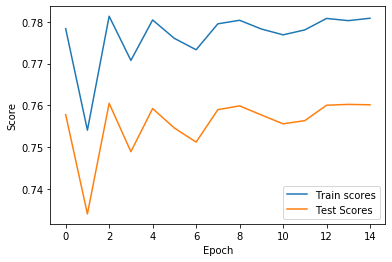

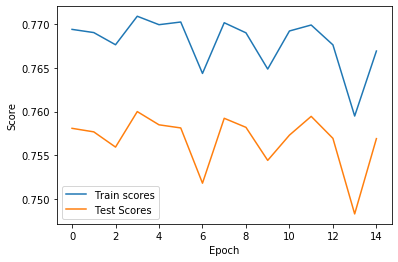

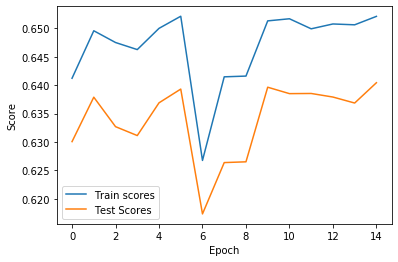

In [33]:
plotScores(full_fs_scores_train, full_fs_scores_test)
plotScores(lw_fs_scores_train, lw_fs_scores_test)
plotScores(custom_fs_scores_train, custom_fs_scores_test)

### Prediction

In [34]:
mlp_prediction_full = full_fs_mlp.predict(X_full_test)
mlp_prediction_lw = lw_fs_mlp.predict(X_lw_test)
mlp_prediction_custom = custom_fs_mlp.predict(X_custom_test)


### Evaluate

In [35]:
mlp_full_mae = mean_absolute_error(mlp_prediction_full, y_test.values)
mlp_lw_mae = mean_absolute_error(mlp_prediction_lw, y_test.values)
mlp_custom_mae = mean_absolute_error(mlp_prediction_custom, y_test.values)

mlp_full_mse = mean_squared_error(mlp_prediction_full, y_test.values)
mlp_lw_mse = mean_squared_error(mlp_prediction_lw, y_test.values)
mlp_custom_mse = mean_squared_error(mlp_prediction_custom, y_test.values)

print("Mean absolute error for mlp method with the full feature set: ", mlp_full_mae)
print("Mean absolute error for mlp method with the lightweight feature set: ", mlp_lw_mae)
print("Mean absolute error for mlp method with the custom feature set: ", mlp_custom_mae)
print()
print("Mean squared error for mlp method with the full feature set: ", mlp_full_mse)
print("Mean squared error for mlp method with the lightweight feature set: ", mlp_lw_mse)
print("Mean squared error for mlp method with the custom feature set: ", mlp_custom_mse)

Mean absolute error for mlp method with the full feature set:  5.265335262983338
Mean absolute error for mlp method with the lightweight feature set:  5.269018414476778
Mean absolute error for basic method with the custom feature set:  6.345970784208543

Mean squared error for mlp method with the full feature set:  45.0585300786934
Mean squared error for mlp method with the lightweight feature set:  45.66248708054821
Mean squared error for mlp method with the custom feature set:  67.54181759732987


## References

- One hot encoding using pandas: http://www.insightsbot.com/blog/zuyVu/python-one-hot-encoding-with-pandas-made-simple
- Change the date column: https://stackoverflow.com/questions/21954197/which-is-the-fastest-way-to-extract-day-month-and-year-from-a-given-date
- Defensive rating definition: https://www.basketball-reference.com/leagues/NBA_2019_ratings.html
- Use of requests in python: https://www.geeksforgeeks.org/get-post-requests-using-python/
- Handling of request exceptions: https://stackoverflow.com/questions/16511337/correct-way-to-try-except-using-python-requests-module
- Add column to pandas dataframe based on other columns: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
- concat dataframes on x axis: https://stackoverflow.com/questions/47655296/pandas-merge-two-datasets-with-same-number-of
- Evaluating regression models: https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4

## Regression Decision Tree

Next, we'll train a regression tree and use it to predict fantasy scores. We will use the same three versions of the dataset and the same training data split: X_full_train, X_full_test, X_lw_train, X_lw_test, X_custom_train, X_custom_test, y_train, y_test.  

Since the depth of a regression decision tree can reach N -1 (where N is the number of element in the dataset). That is because the least effective split will only remove one element for every decision. This is obviously not what we want and we will need to set a max_depth so the tree doesn't get too big. 

In [72]:
from sklearn.tree import DecisionTreeRegressor  

full_fs_rtree = DecisionTreeRegressor(random_state = 0, splitter="random")
lw_fs_rtree = DecisionTreeRegressor(random_state = 0, splitter="random")
custom_fs_rtree = DecisionTreeRegressor(random_state = 0, splitter="random")

TODO: explain why one hot is not good here so we need to rebuild full_feature dataset

In [90]:
# full_feature_set is the source for the first dataset that we are using
# we want to go back to the original to get rid of the one hot encoding
X_full_ft_V2 = dataset_raw[full_feature_set].copy()
#Just reusing the same pre-processing that was used on the original X_full_ft dataset
X_full_ft_V2 = X_full_ft_V2.drop(rows_to_remove)

X_full_train_V2, X_full_test_V2, X_lw_train, X_lw_test, X_custom_train, X_custom_test, y_train, y_test = train_test_split(X_full_ft_V2, X_lightweight_ft, X_custom_ft, y, test_size = 0.2, random_state=1)

(25494, 75)
(25494, 51)
(25494, 54)
(25494,)


In [91]:
rtree_full = full_fs_rtree.fit(X_full_train_V2, y_train)
rtree_lw = lw_fs_rtree.fit(X_lw_train, y_train)
rtree_custom = custom_fs_rtree.fit(X_custom_train, y_train)

ValueError: could not convert string to float: 'Andre Roberson'

### Prediction

In [80]:
rtree_prediction_full = rtree_full.predict(X_full_test_V2)
rtree_prediction_lw = rtree_lw.predict(X_lw_test)
rtree_prediction_custom = rtree_custom.predict(X_custom_test)

### Evaluate

In [81]:
rtree_full_mae = mean_absolute_error(rtree_prediction_full, y_test.values)
rtree_lw_mae = mean_absolute_error(rtree_prediction_lw, y_test.values)
rtree_custom_mae = mean_absolute_error(rtree_prediction_custom, y_test.values)

rtree_full_mse = mean_squared_error(rtree_prediction_full, y_test.values)
rtree_lw_mse = mean_squared_error(rtree_prediction_lw, y_test.values)
rtree_custom_mse = mean_squared_error(rtree_prediction_custom, y_test.values)

print("Mean absolute error for regression tree method with the full feature set: ", rtree_full_mae)
print("Mean absolute error for regression tree method with the lightweight feature set: ", rtree_lw_mae)
print("Mean absolute error for regression tree method with the custom feature set: ", rtree_custom_mae)
print()
print("Mean squared error for regression tree method with the full feature set: ", rtree_full_mse)
print("Mean squared error for regression tree method with the lightweight feature set: ", rtree_lw_mse)
print("Mean squared error for regression tree method with the custom feature set: ", rtree_custom_mse)

Mean absolute error for regression tree method with the full feature set:  5.42702490684448
Mean absolute error for regression tree method with the lightweight feature set:  5.51688729816304
Mean absolute error for regression tree method with the custom feature set:  7.0065944302804475
Mean absolute error for regression tree method with the full feature set:  5.42702490684448

Mean squared error for regression tree method with the full feature set:  65.77968792900569
Mean squared error for regression tree method with the lightweight feature set:  67.33593857591902
Mean squared error for regression tree method with the custom feature set:  114.06554508236908
Mean squared error for regression tree method with the full feature set:  65.77968792900569


In [55]:
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'splitter': ['best', 'random'],
    'max_depth': [10,100,1000,None],
    'min_samples_split': [2,10,100,0.1,0.2],
    'min_samples_leaf': [1,5,10,0.01,0.1]
}

print("Start optimisation:" + str(datetime.datetime.now()))
test = GridSearchCV(full_fs_rtree, parameter_space, n_jobs=-1, cv=3)
test_full = test.fit(X_full_train, y_train)
print("End optimisation:" + str(datetime.datetime.now()))
test_prediction = test_full.predict(X_full_test)
test_mae = mean_absolute_error(test_prediction, y_test.values)
test_mse = mean_squared_error(test_prediction, y_test.values)
print("Mean absolute error for regression tree method with the full feature set: ", test_mae)
print("Mean squared error for regression tree method with the full feature set: ", test_mse)

Start optimisation:2019-11-19 20:38:06.091028
End optimisation:2019-11-19 22:38:43.883294
Mean absolute error for regression tree method with the full feature set:  5.345555704129279
Mean squared error for regression tree method with the full feature set:  46.24443132959062


In [59]:
#JUST TESTING SERIALIZATION OF THE MODEL

#from joblib import dump, load
#dump(test_full, 'rtree_full_optimized.joblib')
#rtree_full_optimized = load('rtree_full_optimized.joblib')

import pickle

filename = 'rtree_full_dump'
outfile = open(filename,'wb')

rtree_full_dump = pickle.dump(test_full, outfile)
outfile.close()

infile = open(filename,'rb')
test2 = pickle.load(infile)
infile.close()
pred = test2.predict(X_full_test)
print("Mean absolute error for regression tree method with the full feature set: ", mean_absolute_error(pred, y_test.values))
#rtree_full_optimized = pickle.loads(rtree_full_dump)
#rtree_full_optimized.predict(X[0:1])

Mean absolute error for regression tree method with the full feature set:  5.345555704129279
